<a href="https://colab.research.google.com/github/Barabaika/rna-cite-compit2022/blob/scMVP/cite_3_inps_cnn_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install colorama
!pip install tensorflow-addons
!pip install keras-tuner
import os, gc, pickle, datetime, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from colorama import Fore, Back, Style

from sklearn.model_selection import KFold,GroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
# from sklearn.decomposition import TruncatedSVD

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, LayerNormalization, Layer, MultiHeadAttention, Reshape, Attention, Conv1D, \
    MaxPool1D, Dropout, BatchNormalization, Flatten, AveragePooling1D, Multiply

from tensorflow_addons.layers import WeightNormalization, AdaptiveAveragePooling1D

from tensorflow.keras.utils import plot_model
import keras_tuner
from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import minmax_scale

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 46.0 MB/s 


In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

!mkdir /root/.kaggle
!cp /content/gdrive/MyDrive/kaggle/kaggle.json /root/.kaggle


!mkdir data
!unzip /content/gdrive/MyDrive/kaggle/metadata.csv.zip -d data
!unzip /content/gdrive/MyDrive/kaggle/train_cite_targets.h5.zip -d data

!kaggle datasets download -d geraseva/target-genes-denoised
!kaggle datasets download -d geraseva/cite-inputs-dca-pca
!kaggle datasets download -d grac2h5/top-100-closest-to-target-genes-with-features

!unzip -q target-genes-denoised.zip -d data
!unzip -q cite-inputs-dca-pca.zip -d data
!unzip -q top-100-closest-to-target-genes-with-features -d data

Mounted at /content/gdrive
Archive:  /content/gdrive/MyDrive/kaggle/metadata.csv.zip
  inflating: data/metadata.csv       
Archive:  /content/gdrive/MyDrive/kaggle/train_cite_targets.h5.zip
  inflating: data/train_cite_targets.h5  
 98% 631M/645M [00:04<00:00, 145MB/s]
100% 645M/645M [00:05<00:00, 135MB/s]
 80% 85.0M/106M [00:00<00:00, 117MB/s] 
100% 106M/106M [00:00<00:00, 124MB/s] 
100% 3.40G/3.40G [00:33<00:00, 102MB/s] 
100% 3.40G/3.40G [00:33<00:00, 109MB/s]


In [3]:
DATA_DIR = "/content/data"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")

TUNE = False
SUBMIT = True

In [4]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def negative_correlation_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, y_true.shape[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(y_true.shape[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

def std(x):
    return (x - np.mean(x)) / np.std(x)

In [5]:
X_imp_genes = pd.read_csv('/content/data/citeseq_target_genes_denoised_dca.csv')
X_imp_genes = X_imp_genes.set_index('cell_id')

X_train_imp_genes = X_imp_genes.iloc[:70988, :].values
X_test_imp_genes = X_imp_genes.iloc[70988:, :].values

assert X_test_imp_genes.shape[0] == 48663

meta = pd.read_csv(FP_CELL_METADATA, index_col='cell_id')
meta = meta.reindex(X_imp_genes.iloc[:70988, :].index)
print(meta.shape)

del X_imp_genes
gc.collect()

(70988, 4)


22

In [6]:
X_dim_red = pd.read_csv('/content/data/cite_inputs_dca_denoised_PCA200.csv')
X_dim_red = X_dim_red.drop('Unnamed: 0', axis = 1)

X_train_dim_red = X_dim_red.iloc[:70988, :].values
X_test_dim_red = X_dim_red.iloc[70988:, :].values

del X_dim_red
gc.collect()

22

In [7]:
#loading data from Antom (top 100 closest to tagret genes with features)
top100_folder = 'mean_by_target_denoised/'
list_f = [
    os.path.join(DATA_DIR, top100_folder, 'anti-human_CD63_semantic_similarity.csv'),
    os.path.join(DATA_DIR, top100_folder, 'anti-human_CD49b_semantic_similarity.csv'),
    os.path.join(DATA_DIR, top100_folder, 'anti-human_CD62L_semantic_similarity.csv'),
    os.path.join(DATA_DIR, top100_folder, 'anti-human_HLA-DR_semantic_similarity.csv')
         ]
list_d = []
for f in list_f:
    d = pd.read_csv(f, index_col = 0)
    list_d.append(d)


X_all_conected = pd.concat(list_d, axis = 1)
# constant_in_conected = [i.split('_')[1] for i in constant_cols if i.split('_')[1] in X_all_conected.columns]
# X_all_conected = X_all_conected.drop(constant_in_conected, axis = 1)
X_all_conected.shape

X_train_connect = X_all_conected.iloc[:70988, :].values
X_test_connect = X_all_conected.iloc[70988:, :].values

print(X_train_connect.shape)
print(X_test_connect.shape)

(70988, 220)
(48663, 220)


In [8]:
# std scaling:

X_train_dim_red = std(X_train_dim_red) # minmax_scale
X_test_dim_red = std(X_test_dim_red)

X_train_connect = std(X_train_connect)
X_test_connect = std(X_test_connect)

X_train_imp_genes = std(X_train_imp_genes)
X_test_imp_genes = std(X_test_imp_genes)

In [9]:
# Read Y
Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
y_columns = list(Y.columns)
Y = Y.values

# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
Y = std(Y)

print(f"Y shape: {str(Y.shape):14} {Y.size*4/1024/1024/1024:2.3f} GByte")

Y shape: (70988, 140)   0.037 GByte


In [10]:
scol = 'donor&day&CT'
meta[scol] =meta['donor'].apply(lambda x:str(x)+'_') + meta['day'].apply(lambda x:str(x)+'_') + meta['cell_type']
meta

y = meta[scol] 
skf = StratifiedKFold(n_splits=10,  shuffle=True, random_state=40)
skf.get_n_splits(meta, meta[scol] )
for train_index, test_index in skf.split(meta, meta[scol]):
    print("TRAIN:", len(train_index), "TEST:", len(test_index) ); break

meta['HoldOut'] = 0 
meta.loc[meta.index[test_index],'HoldOut']  = 1


list_folds_indices_by_days_and_donors_with2holdouts = []
c = 0
for day2exclude in [2,3,4]:
    for donor2exclude in [32606,  31800]: # We will need to predict always MALE (not female) - like on LB. (# donor 13176 - female)
        train_index = np.where( (meta['day']  != day2exclude) & ( meta['donor']  != donor2exclude  ) )  [0]
        mask_holdout = (meta['HoldOut']==1)
        test_index1_like_private_lb = np.where( (meta['day']  == day2exclude) & (~mask_holdout) ) [0]
        test_index1_like_private_lb_holdout = np.where( (meta['day']  == day2exclude) & (mask_holdout) ) [0]
        test_index2_like_public_lb = np.where( (meta['day']  != day2exclude) &  (meta['donor']  == donor2exclude ) & (~mask_holdout) ) [0]
        test_index2_like_public_lb_holdout = np.where( (meta['day']  != day2exclude) &  (meta['donor']  == donor2exclude ) & mask_holdout ) [0]
        
        list_folds_indices_by_days_and_donors_with2holdouts.append( 
            (train_index,  
             test_index1_like_private_lb , 
             test_index2_like_public_lb, 
             test_index1_like_private_lb_holdout, 
             test_index2_like_public_lb_holdout ) 
        )
    
        str_fold_inf = 'Fold ' +str(c) + ': Train: excludes Day '+str(day2exclude) + ' and Donor ' + str( donor2exclude )
        print(str_fold_inf, 'Sizes: train:',len(train_index), 'Test Like Priv'  ,len(test_index1_like_private_lb), 
              'Test Like Publ',   len(test_index2_like_public_lb),  
              'Test Like Priv HoldOut',   len(test_index1_like_private_lb_holdout),  
              'Test Like Publ HoldOut',   len(test_index2_like_public_lb_holdout),  
              
             ); c+=1
    
print(len(list_folds_indices_by_days_and_donors_with2holdouts))

TRAIN: 63889 TEST: 7099
Fold 0: Train: excludes Day 2 and Donor 32606 Sizes: train: 32536 Test Like Priv 19748 Test Like Publ 14859 Test Like Priv HoldOut 2194 Test Like Publ HoldOut 1651
Fold 1: Train: excludes Day 2 and Donor 31800 Sizes: train: 32638 Test Like Priv 19748 Test Like Publ 14767 Test Like Priv HoldOut 2194 Test Like Publ HoldOut 1641
Fold 2: Train: excludes Day 3 and Donor 32606 Sizes: train: 33100 Test Like Priv 18811 Test Like Publ 15288 Test Like Priv HoldOut 2090 Test Like Publ HoldOut 1699
Fold 3: Train: excludes Day 3 and Donor 31800 Sizes: train: 31543 Test Like Priv 18811 Test Like Publ 16690 Test Like Priv HoldOut 2090 Test Like Publ HoldOut 1854
Fold 4: Train: excludes Day 4 and Donor 32606 Sizes: train: 28368 Test Like Priv 25330 Test Like Publ 13027 Test Like Priv HoldOut 2815 Test Like Publ HoldOut 1448
Fold 5: Train: excludes Day 4 and Donor 31800 Sizes: train: 28189 Test Like Priv 25330 Test Like Publ 13189 Test Like Priv HoldOut 2815 Test Like Publ HoldO

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


In [11]:
def get_fold(fold_number, X, Y, fold_map):
    '''
    fold_map
    X: sparce matrix
    '''
    
    X_train = X[fold_map[int(fold_number)][0]]
    
    X_test_priv = X[fold_map[int(fold_number)][1]]
    X_test_publ = X[fold_map[int(fold_number)][2]]
    
    X_test_priv_holdout = X[fold_map[int(fold_number)][3]]
    X_test_publ_holdout = X[fold_map[int(fold_number)][4]]
    
    Y_train = Y[fold_map[int(fold_number)][0]]
    
    Y_test_priv = Y[fold_map[int(fold_number)][1]]
    Y_test_publ = Y[fold_map[int(fold_number)][2]]
    
    Y_test_priv_holdout = Y[fold_map[int(fold_number)][3]]
    Y_test_publ_holdout = Y[fold_map[int(fold_number)][4]]
    
    return X_train, X_test_priv, X_test_publ, X_test_priv_holdout, X_test_publ_holdout, Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout

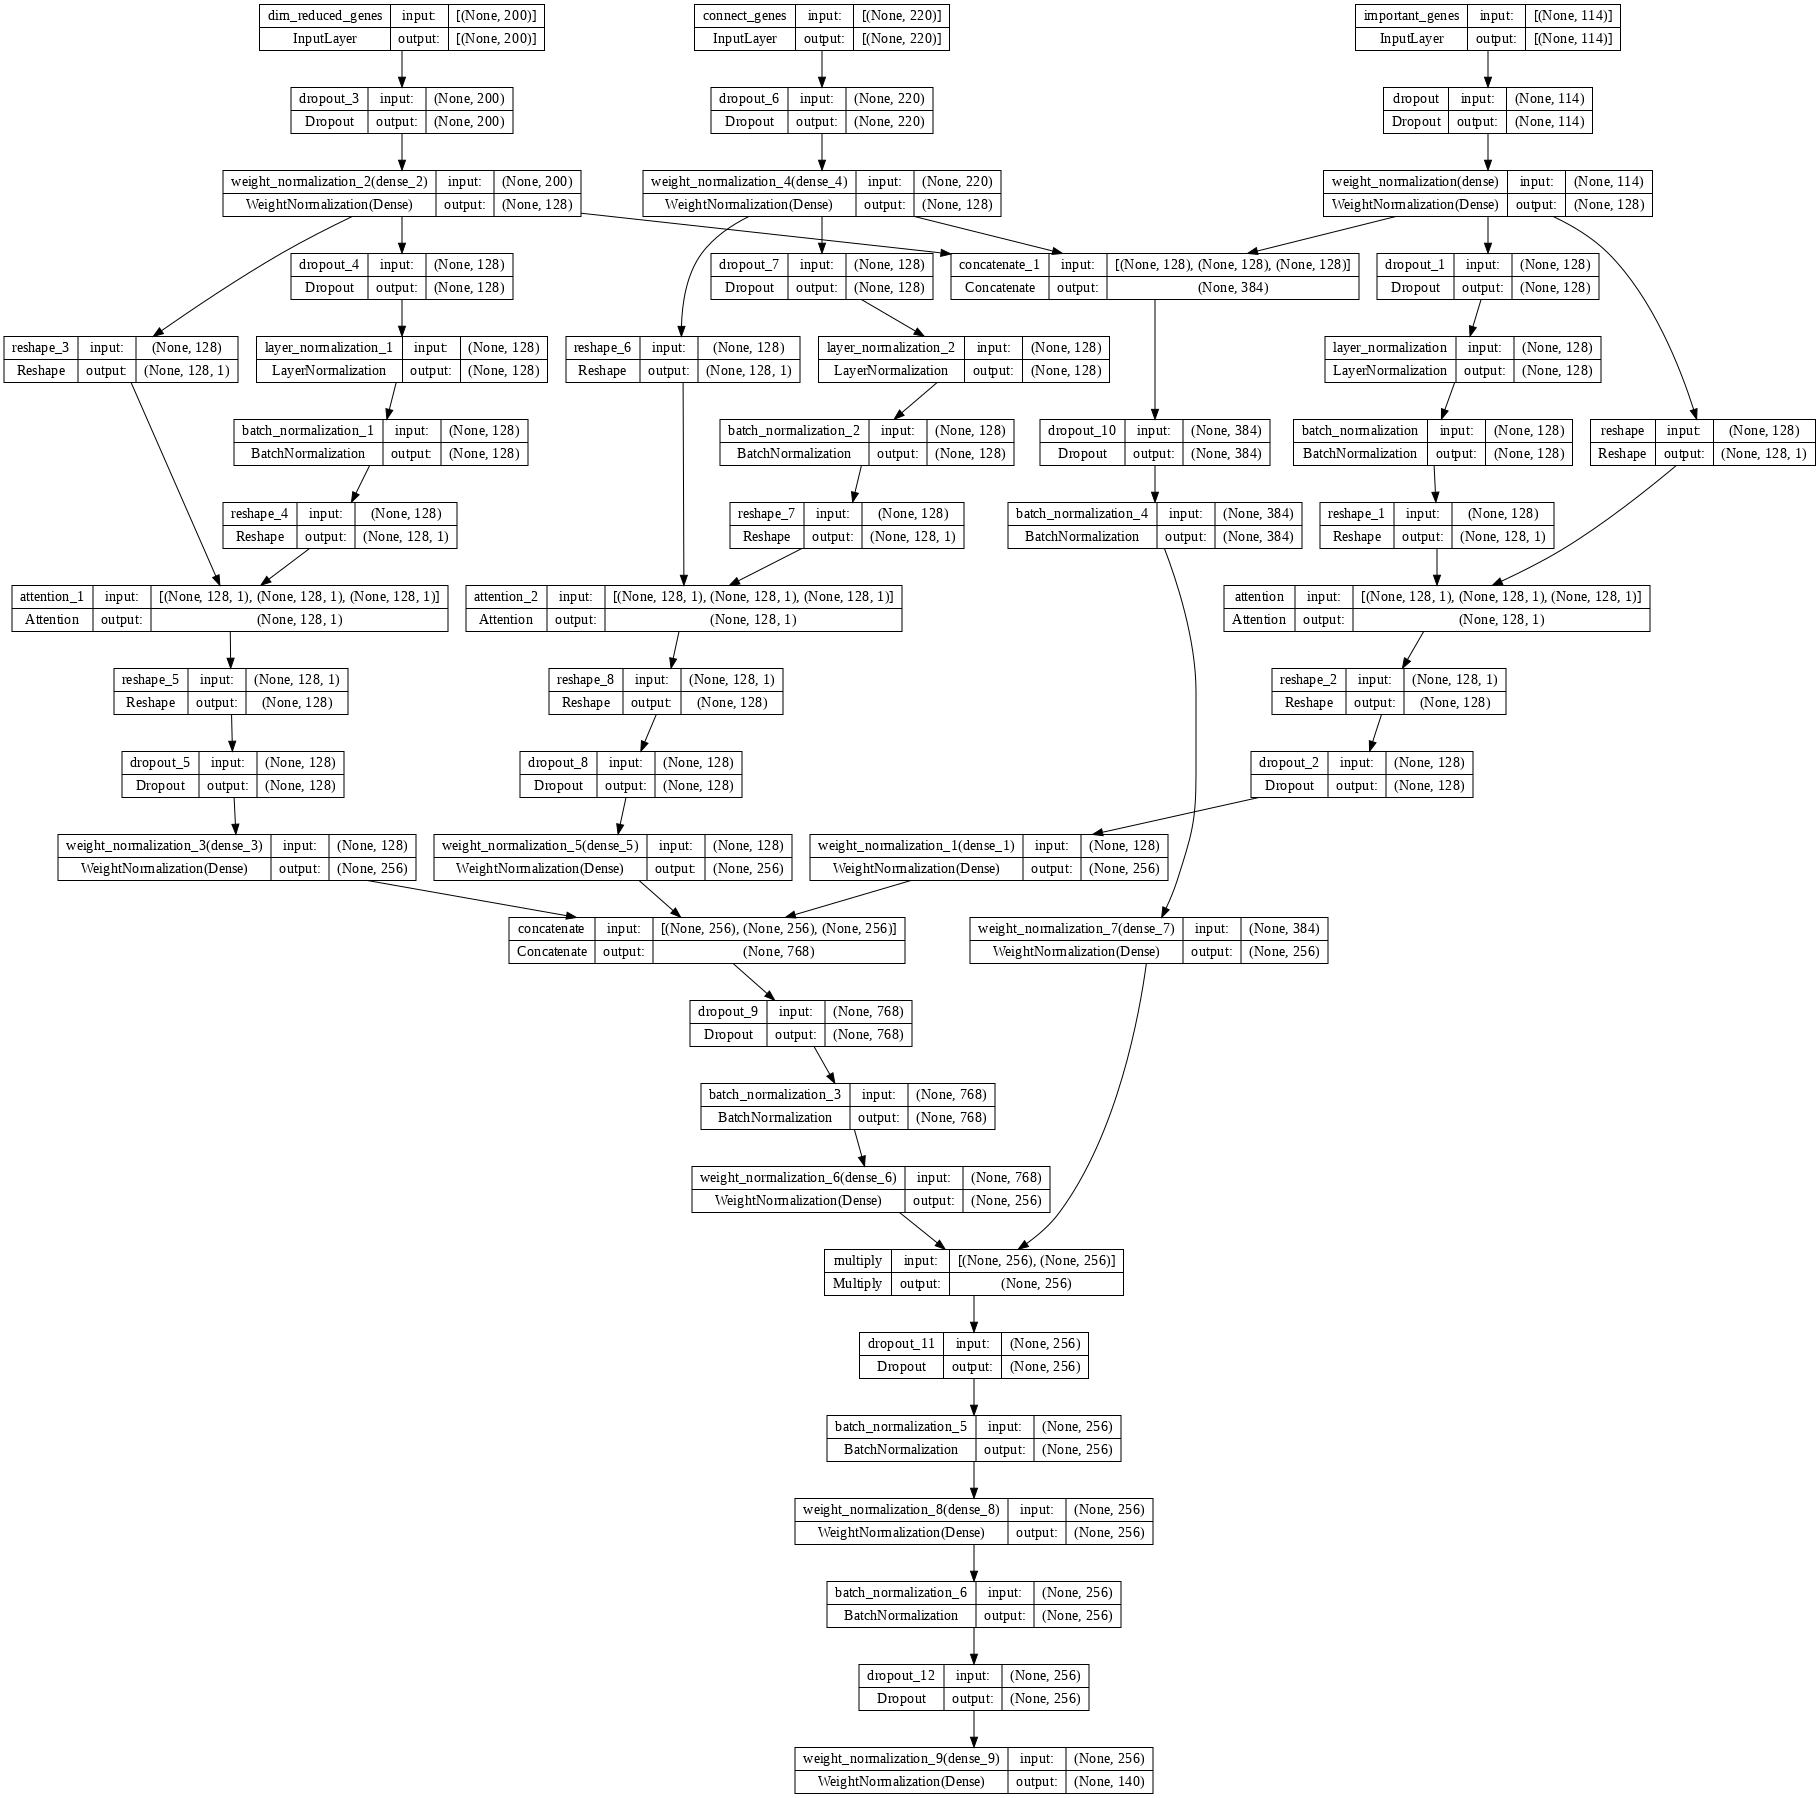

In [12]:
LR_START = 0.01
BATCH_SIZE = 256
def my_model(hp, n_inputs_imp_genes = 114, n_inputs_dim_red = 200, n_inputs_connect = 220):    
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """
    activation_first = hp.Choice('activation_first', ['tanh', 'elu', "swish", 'gelu', 'relu'])
    activation = hp.Choice('activation_other', ['elu', "swish", 'gelu', 'relu', 'tanh'])

#     reg1 = hp.Float("reg1", min_value=1e-8, max_value=1e-4, sampling="log")
#     reg2 = hp.Float("reg2", min_value=1e-10, max_value=1e-5, sampling="log")
    
    important_genes_input = Input(shape=(n_inputs_imp_genes, ), name="important_genes")
    dim_reduced_genes_input = Input(shape=(n_inputs_dim_red, ), name = "dim_reduced_genes")
    connect_genes_input = Input(shape=(n_inputs_connect, ), name = "connect_genes")
    
    x_dict = {'important_genes':important_genes_input, 
          'dim_reduced_genes':dim_reduced_genes_input, 
          'connect_genes':connect_genes_input}
    # x = Concatenate()([important_genes_input, dim_reduced_genes_input, connect_genes_input])
    
    # hidden_size = hp.Choice('hidden_size', [2048, 4096], default = 4096)
    first_dence = hp.Choice('first_dence', [64, 128, 256, 512], default = 128)
    second_dence =hp.Choice('second_dence', [128, 256, 512, 1024], default = 256)
    third_dence =hp.Choice('third_dence', [128, 256, 512, 1024], default = 256)
    forth_dence =hp.Choice('forth_dence', [128, 256, 512, 1024], default = 256)
    num_targets = Y.shape[1]
    
    X_dot_list = []
    for key in x_dict.keys():

      x_dict[key] = Dropout(0.1)(x_dict[key])
      x_dict[key] = WeightNormalization(
          Dense(first_dence, activation = activation_first),
          data_init=False
      )(x_dict[key])
      tmp_mask = x_dict[key]
      X_dot_list.append(tmp_mask)
      
      tmp_mask = Reshape((tmp_mask.shape[1], 1))(tmp_mask)
      
      x_dict[key] = Dropout(0.1)(x_dict[key])
      x_dict[key] = LayerNormalization()(x_dict[key])
      x_dict[key] = BatchNormalization()(x_dict[key])

      x_dict[key] = Reshape((x_dict[key].shape[1], 1))(x_dict[key])
      x_dict[key] = Attention(use_scale = True)([x_dict[key], tmp_mask, x_dict[key]])

      x_dict[key] = Reshape((x_dict[key].shape[1], ))(x_dict[key])
      x_dict[key] = Dropout(0.1)(x_dict[key])
      x_dict[key] = WeightNormalization(
          Dense(second_dence, activation = activation_first),
          data_init=False
      )(x_dict[key])

      
    x = Concatenate()(list(x_dict.values()))
    x = Dropout(0.1)(x)
    x = BatchNormalization(axis=1)(x)
    x = WeightNormalization(
        Dense(third_dence, activation = activation),
        data_init=False
    )(x)

    x_dot = Concatenate()(X_dot_list)
    x_dot = Dropout(0.1)(x_dot)
    x_dot = BatchNormalization(axis=1)(x_dot)
    x_dot = WeightNormalization(
        Dense(third_dence, activation = activation),
        data_init=False
    )(x_dot)

    x = Multiply()([x, x_dot])

    x = Dropout(0.1)(x)
    x = BatchNormalization(axis=1)(x)
    x = WeightNormalization(
        Dense(forth_dence, activation = activation),
        data_init=False
    )(x)

    x = BatchNormalization(axis=1)(x)
    x = Dropout(0.2)(x)
    x = WeightNormalization(
        Dense(num_targets, 
#               activation = activation_first
             ),
        data_init=False
    )(x)
     
    regressor = Model(
        inputs= [important_genes_input, dim_reduced_genes_input, connect_genes_input], 
        outputs = x
    )
    regressor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
                      metrics=[negative_correlation_loss],
                      loss=negative_correlation_loss
                     )
    
    return regressor
display(plot_model(my_model(keras_tuner.HyperParameters()), show_layer_names=True, show_shapes=True, dpi=72))

In [ ]:
%%time
cv_idxs = list_folds_indices_by_days_and_donors_with2holdouts
FOLD  = 0
TUNE = False
if TUNE:
#     X_file = 'citeseq_FAfromPCA200_n_components50rs0.csv'

    tuner = keras_tuner.BayesianOptimization(
        my_model,
        overwrite=True,
        objective = keras_tuner.Objective("val_negative_correlation_loss", direction="min"),
        max_trials = 100,
        directory='/kaggle/temp',
        seed=1)

    lr = ReduceLROnPlateau(monitor="val_loss", factor = 0.5, 
                           patience = 4, verbose=0)
    es = EarlyStopping(monitor = "val_loss",
                       patience = 12, 
                       verbose= 0,
                       mode = "min", 
                       restore_best_weights = True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]
    
    
    X_tr_imp_genes, X_test_priv_imp_genes, X_test_publ_imp_genes, X_test_priv_imp_genes_holdout, X_test_publ_imp_genes_holdout, \
    Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(FOLD, X_train_imp_genes, Y, cv_idxs)
    
    X_tr_dim_red, X_test_priv_dim_red, X_test_publ_dim_red, X_test_priv_dim_red_holdout, X_test_publ_dim_red_holdout, \
    Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(FOLD, X_train_dim_red, Y, cv_idxs)
    
    X_tr_connect, X_test_priv_connect, X_test_publ_connect, X_test_priv_connect_holdout, X_test_publ_connect_holdout, \
    Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(FOLD, X_train_connect, Y, cv_idxs)
    
    X_tr_dict = {'important_genes':X_tr_imp_genes, 'dim_reduced_genes':X_tr_dim_red, 'connect_genes':X_tr_connect}
    X_test_private_dict = {'important_genes':X_test_priv_imp_genes, 'dim_reduced_genes':X_test_priv_dim_red, 'connect_genes':X_test_priv_connect}
    X_test_publ_dict = {'important_genes':X_test_publ_imp_genes, 'dim_reduced_genes':X_test_publ_dim_red, 'connect_genes':X_test_publ_connect}
    
    
    tuner.search(X_tr_dict, 
                 Y_train,
                 epochs = 1000,
                 validation_data = (X_test_private_dict, Y_test_priv),
                 batch_size = BATCH_SIZE,
                 callbacks = callbacks, verbose=2)
    
#     del X_tr, X_va, y_tr, y_va, lr, es, callbacks

Trial 63 Complete [00h 07m 50s]
val_negative_correlation_loss: -0.8418150544166565

Best val_negative_correlation_loss So Far: -0.842633068561554
Total elapsed time: 07h 59m 07s

Search: Running Trial #64

Value             |Best Value So Far |Hyperparameter
relu              |relu              |activation_first
tanh              |tanh              |activation_other
512               |512               |first_dence
128               |128               |second_dence
128               |128               |third_dence
1024              |1024              |forth_dence

Epoch 1/1000


In [ ]:
if TUNE:
    tuner.results_summary()
    pd.DataFrame([hp.values for hp in tuner.get_best_hyperparameters(10)]).to_csv('Best_params.csv')
    # Table of the 10 best trials
    display(pd.DataFrame([hp.values for hp in tuner.get_best_hyperparameters(10)]))
    
    # Keep the best hyperparameters
    best_hp = tuner.get_best_hyperparameters(1)[0]
    
    display(plot_model(my_model(best_hp), show_layer_names=False, show_shapes=True, dpi=72))

Best val_negative_correlation_loss So Far: -0.842633068561554
Total elapsed time: 07h 59m 07s

Search: Running Trial #64

Value             |Best Value So Far |Hyperparameter
relu              |relu              |activation_first
tanh              |tanh              |activation_other
512               |512               |first_dence
128               |128               |second_dence
128               |128               |third_dence
1024              |1024              |forth_dence

In [13]:

best_hp = keras_tuner.HyperParameters()
best_hp.values = {
    'first_dence':512,
    'second_dence':128,
    'third_dence':128,
    'forth_dence':1024,
    'activation_first': 'relu',
    'activation': 'tanh',
}

Epoch 1/300
128/128 - 26s - loss: -8.1558e-01 - negative_correlation_loss: -8.1536e-01 - val_loss: -7.6702e-01 - val_negative_correlation_loss: -7.6642e-01 - lr: 0.0100 - 26s/epoch - 205ms/step
Epoch 2/300
128/128 - 15s - loss: -8.6706e-01 - negative_correlation_loss: -8.6728e-01 - val_loss: -7.8806e-01 - val_negative_correlation_loss: -7.8747e-01 - lr: 0.0100 - 15s/epoch - 116ms/step
Epoch 3/300
128/128 - 15s - loss: -8.7111e-01 - negative_correlation_loss: -8.7061e-01 - val_loss: -7.9499e-01 - val_negative_correlation_loss: -7.9440e-01 - lr: 0.0100 - 15s/epoch - 116ms/step
Epoch 4/300
128/128 - 15s - loss: -8.6972e-01 - negative_correlation_loss: -8.7033e-01 - val_loss: -7.9659e-01 - val_negative_correlation_loss: -7.9614e-01 - lr: 0.0100 - 15s/epoch - 118ms/step
Epoch 5/300
128/128 - 16s - loss: -8.7308e-01 - negative_correlation_loss: -8.7300e-01 - val_loss: -7.9924e-01 - val_negative_correlation_loss: -7.9880e-01 - lr: 0.0100 - 16s/epoch - 121ms/step
Epoch 6/300
128/128 - 15s - lo

101/101 [==============================] - 5s 41ms/step
Fold 0: stopped after  29 epochs
   corr TRAIN=  0.89571
101/101 [==============================] - 2s 21ms/step
   corr PUBLIC=  0.89343
101/101 [==============================] - 3s 27ms/step
   corr PRIVATE=  0.88484
Epoch 1/300
128/128 - 22s - loss: -8.1048e-01 - negative_correlation_loss: -8.1058e-01 - val_loss: -7.6406e-01 - val_negative_correlation_loss: -7.6381e-01 - lr: 0.0100 - 22s/epoch - 171ms/step
Epoch 2/300
128/128 - 16s - loss: -8.6886e-01 - negative_correlation_loss: -8.6886e-01 - val_loss: -7.8378e-01 - val_negative_correlation_loss: -7.8354e-01 - lr: 0.0100 - 16s/epoch - 121ms/step
Epoch 3/300
128/128 - 15s - loss: -8.7327e-01 - negative_correlation_loss: -8.7325e-01 - val_loss: -7.8864e-01 - val_negative_correlation_loss: -7.8840e-01 - lr: 0.0100 - 15s/epoch - 116ms/step
Epoch 4/300
128/128 - 15s - loss: -8.7499e-01 - negative_correlation_loss: -8.7489e-01 - val_loss: -7.9107e-01 - val_negative_correlation_loss

101/101 [==============================] - 7s 45ms/step
Fold 1: stopped after  41 epochs
   corr TRAIN=  0.90491
101/101 [==============================] - 2s 24ms/step
   corr PUBLIC=  0.87842
101/101 [==============================] - 3s 27ms/step
   corr PRIVATE=  0.88484
Epoch 1/300
130/130 - 22s - loss: -8.1225e-01 - negative_correlation_loss: -8.1259e-01 - val_loss: -7.2649e-01 - val_negative_correlation_loss: -7.2657e-01 - lr: 0.0100 - 22s/epoch - 173ms/step
Epoch 2/300
130/130 - 15s - loss: -8.6815e-01 - negative_correlation_loss: -8.6820e-01 - val_loss: -7.4248e-01 - val_negative_correlation_loss: -7.4256e-01 - lr: 0.0100 - 15s/epoch - 116ms/step
Epoch 3/300
130/130 - 15s - loss: -8.7201e-01 - negative_correlation_loss: -8.7199e-01 - val_loss: -7.4642e-01 - val_negative_correlation_loss: -7.4650e-01 - lr: 0.0100 - 15s/epoch - 116ms/step
Epoch 4/300
130/130 - 15s - loss: -8.7410e-01 - negative_correlation_loss: -8.7407e-01 - val_loss: -7.4701e-01 - val_negative_correlation_loss

100/100 [==============================] - 5s 42ms/step
Fold 2: stopped after  32 epochs
   corr TRAIN=  0.89753
101/101 [==============================] - 4s 22ms/step
   corr PUBLIC=  0.88617
101/101 [==============================] - 3s 26ms/step
   corr PRIVATE=  0.89075
Epoch 1/300
124/124 - 25s - loss: -8.1707e-01 - negative_correlation_loss: -8.1663e-01 - val_loss: -7.0322e-01 - val_negative_correlation_loss: -7.0335e-01 - lr: 0.0100 - 25s/epoch - 203ms/step
Epoch 2/300
124/124 - 15s - loss: -8.6702e-01 - negative_correlation_loss: -8.6661e-01 - val_loss: -7.5459e-01 - val_negative_correlation_loss: -7.5497e-01 - lr: 0.0100 - 15s/epoch - 118ms/step
Epoch 3/300
124/124 - 15s - loss: -8.7168e-01 - negative_correlation_loss: -8.7152e-01 - val_loss: -7.5635e-01 - val_negative_correlation_loss: -7.5674e-01 - lr: 0.0100 - 15s/epoch - 118ms/step
Epoch 4/300
124/124 - 15s - loss: -8.7356e-01 - negative_correlation_loss: -8.7352e-01 - val_loss: -7.5882e-01 - val_negative_correlation_loss

101/101 [==============================] - 5s 40ms/step
Fold 3: stopped after  35 epochs
   corr TRAIN=  0.90220
101/101 [==============================] - 2s 24ms/step
   corr PUBLIC=  0.88057
101/101 [==============================] - 3s 26ms/step
   corr PRIVATE=  0.89089
Epoch 1/300
111/111 - 19s - loss: -8.3883e-01 - negative_correlation_loss: -8.3892e-01 - val_loss: -7.3937e-01 - val_negative_correlation_loss: -7.3950e-01 - lr: 0.0100 - 19s/epoch - 175ms/step
Epoch 2/300
111/111 - 13s - loss: -8.9345e-01 - negative_correlation_loss: -8.9346e-01 - val_loss: -7.7398e-01 - val_negative_correlation_loss: -7.7411e-01 - lr: 0.0100 - 13s/epoch - 116ms/step
Epoch 3/300
111/111 - 13s - loss: -8.9885e-01 - negative_correlation_loss: -8.9884e-01 - val_loss: -7.8270e-01 - val_negative_correlation_loss: -7.8283e-01 - lr: 0.0100 - 13s/epoch - 116ms/step
Epoch 4/300
111/111 - 13s - loss: -9.0108e-01 - negative_correlation_loss: -9.0104e-01 - val_loss: -7.9074e-01 - val_negative_correlation_loss

101/101 [==============================] - 5s 36ms/step
Fold 4: stopped after  37 epochs
   corr TRAIN=  0.90480
101/101 [==============================] - 2s 19ms/step
   corr PUBLIC=  0.88976
101/101 [==============================] - 3s 33ms/step
   corr PRIVATE=  0.87878
Epoch 1/300
111/111 - 19s - loss: -8.2397e-01 - negative_correlation_loss: -8.2410e-01 - val_loss: -7.7627e-01 - val_negative_correlation_loss: -7.7673e-01 - lr: 0.0100 - 19s/epoch - 174ms/step
Epoch 2/300
111/111 - 13s - loss: -8.8542e-01 - negative_correlation_loss: -8.8587e-01 - val_loss: -7.9406e-01 - val_negative_correlation_loss: -7.9451e-01 - lr: 0.0100 - 13s/epoch - 116ms/step
Epoch 3/300
111/111 - 14s - loss: -8.8986e-01 - negative_correlation_loss: -8.9039e-01 - val_loss: -8.0644e-01 - val_negative_correlation_loss: -8.0686e-01 - lr: 0.0100 - 14s/epoch - 124ms/step
Epoch 4/300
111/111 - 14s - loss: -8.9228e-01 - negative_correlation_loss: -8.9159e-01 - val_loss: -8.0910e-01 - val_negative_correlation_loss

101/101 [==============================] - 5s 36ms/step
Fold 5: stopped after  34 epochs
   corr TRAIN=  0.90274
101/101 [==============================] - 2s 20ms/step
   corr PUBLIC=  0.89424
101/101 [==============================] - 3s 33ms/step
   corr PRIVATE=  0.88040
Average  corr PUBLIC = 0.88710
Average  corr PRIVATE= 0.88508


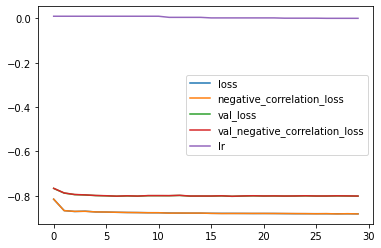

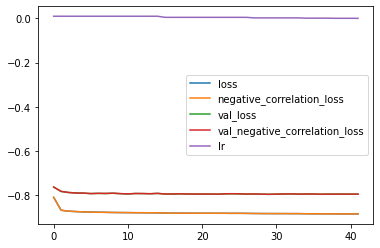

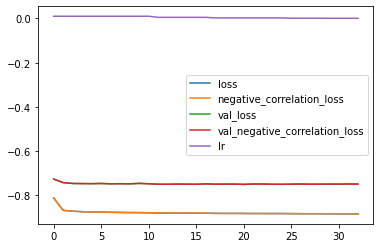

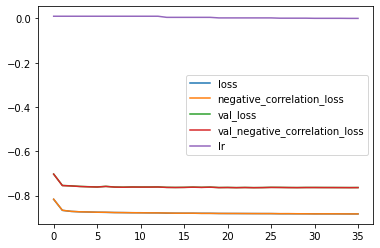

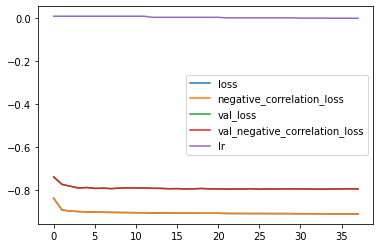

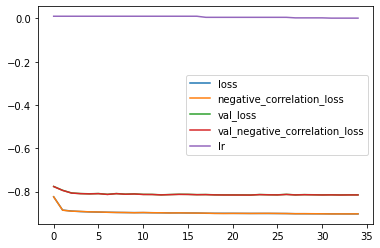

In [14]:
SUBMIT = True

# results
df_fold_score_stat_publ = pd.DataFrame();df_fold_score_stat_publ.index.name = 'dim_red_file'
df_fold_score_stat_priv = pd.DataFrame();df_fold_score_stat_priv.index.name = 'dim_red_file'


# Cross-validation
VERBOSE = 2 # set to 2 for more output
EPOCHS = 300

cv_idxs = list_folds_indices_by_days_and_donors_with2holdouts

np.random.seed(1)
tf.random.set_seed(1)

N_FOLDS = 6

core_list_train = []
score_list_priv = []
score_list_publ = []
va_pred_publ = []
va_pred_priv = []

X_file = '128tSVD+108important_raw_genes+210_connected_genes'


for fold in range(N_FOLDS): # N_FOLDS

    start_time = datetime.datetime.now()
    model = None
    gc.collect()

    X_tr_imp_genes, X_test_priv_imp_genes, X_test_publ_imp_genes, X_test_priv_imp_genes_holdout, X_test_publ_imp_genes_holdout, \
    Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(fold, X_train_imp_genes, Y, cv_idxs)
    
    X_tr_dim_red, X_test_priv_dim_red, X_test_publ_dim_red, X_test_priv_dim_red_holdout, X_test_publ_dim_red_holdout, \
    Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(fold, X_train_dim_red, Y, cv_idxs)
    
    X_tr_connect, X_test_priv_connect, X_test_publ_connect, X_test_priv_connect_holdout, X_test_publ_connect_holdout, \
    Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(fold, X_train_connect, Y, cv_idxs)

    
    X_tr_dict = {'important_genes':X_tr_imp_genes, 'dim_reduced_genes':X_tr_dim_red, 'connect_genes':X_tr_connect}
    X_test_private_dict = {'important_genes':X_test_priv_imp_genes, 'dim_reduced_genes':X_test_priv_dim_red, 'connect_genes':X_test_priv_connect}
    X_test_publ_dict = {'important_genes':X_test_publ_imp_genes, 'dim_reduced_genes':X_test_publ_dim_red, 'connect_genes':X_test_publ_connect}
    

    lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, 
                           patience=4, verbose=VERBOSE)
    es = EarlyStopping(monitor="val_loss",
                       patience=12, 
                       verbose=0,
                       mode="min", 
                       restore_best_weights=True)
    callbacks = [lr, es, tf.keras.callbacks.TerminateOnNaN()]
    
    model = my_model(best_hp, n_inputs_imp_genes = X_tr_imp_genes.shape[1], n_inputs_dim_red= X_tr_dim_red.shape[1], n_inputs_connect= X_tr_connect.shape[1])
    
    history = model.fit(X_tr_dict, 
                         Y_train,
                         epochs = EPOCHS,
                         validation_data = (X_test_private_dict, Y_test_priv),
                        verbose=VERBOSE,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        callbacks=callbacks)
    if SUBMIT:
        model.save(f"/kaggle/temp/model_CNN_{fold}")
    history = history.history
    callbacks, lr = None, None
   
    
    # Print scores on trian to find if the model is overfitting
    y_tr_pred = model.predict(X_tr_dict, batch_size= len(X_tr_imp_genes)//100)
    corrscore = correlation_score(Y_train, y_tr_pred)
    core_list_train.append(corrscore)

    print(f"Fold {fold}: stopped after {es.stopped_epoch:3} epochs")
    print(f"   corr TRAIN=  {corrscore:.5f}")

    # We validate the model on PUBLIC
    y_va_pred = model.predict(X_test_publ_dict, batch_size=len(X_test_publ_imp_genes)//100)
    va_pred_publ.append(y_va_pred)
    corrscore = correlation_score(Y_test_publ, y_va_pred)

    print(f"   corr PUBLIC=  {corrscore:.5f}")
    score_list_publ.append(corrscore)
    df_fold_score_stat_publ.loc[X_file, f'FOLD_{str(fold)}'] = corrscore

    # We validate the model on PRIVATE
    y_va_pred = model.predict(X_test_private_dict, batch_size=len(X_test_priv_imp_genes)//100)
    va_pred_priv.append(y_va_pred)
    corrscore = correlation_score(Y_test_priv, y_va_pred)

    print(f"   corr PRIVATE=  {corrscore:.5f}")
    del es, Y_test_priv
    score_list_priv.append(corrscore)
    df_fold_score_stat_priv.loc[X_file, f'FOLD_{str(fold)}'] = corrscore
    
    pd.DataFrame(history).plot()


# Show overall score
print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr PUBLIC = {np.array(score_list_publ).mean():.5f}{Style.RESET_ALL}")
print(f"{Fore.GREEN}{Style.BRIGHT}Average  corr PRIVATE= {np.array(score_list_priv).mean():.5f}{Style.RESET_ALL}")

df_fold_score_stat_priv.loc[X_file, 'Average'] = np.array(score_list_priv).mean()
df_fold_score_stat_publ.loc[X_file, 'Average'] = np.array(score_list_publ).mean()

df_fold_score_stat_priv.to_csv('Fold_PRIVAT_scores_per_dim_reduction_table.csv')
df_fold_score_stat_publ.to_csv('Fold_PUBLIC_scores_per_dim_reduction_table.csv')


In [15]:
!kaggle kernels output jsmithperera/citeseq-keras-multiome-5x5
!unzip -q citeseq-keras-multiome-5x5.zip -d data

Output file downloaded to /content/model.png
tcmalloc: large alloc 1351139328 bytes == 0x647f8000 @  0x7fef191811e7 0x4b2590 0x5ad01c 0x5ad387 0x4d222f 0x51041f 0x4d14d6 0x57471e 0x50cb08 0x5b4ee6 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad0a 0x4d3249 0x591e56 0x50e18c 0x5b4ee6 0x4bad0a 0x50e18c 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50ca37 0x5b4ee6 0x4bad0a 0x4d3249
Output file downloaded to /content/submission.csv
Kernel log downloaded to /content/citeseq-keras-multiome-5x5.log 
unzip:  cannot find or open citeseq-keras-multiome-5x5.zip, citeseq-keras-multiome-5x5.zip.zip or citeseq-keras-multiome-5x5.zip.ZIP.


In [ ]:
cp -r /kaggle/temp/ /content/gdrive/MyDrive/kaggle

In [17]:

if SUBMIT:
#     test_pred_CNN = np.zeros((len(X_test_imp_genes), 140), dtype=np.float32)
#     for fold in range(N_FOLDS):
#         print(f"Predicting with fold {fold}")
#         model = load_model(f"/kaggle/temp/model_CNN_{fold}",
#                            custom_objects={'negative_correlation_loss': negative_correlation_loss})
        
# #         Xt_imp_genes = Xt[:, -X0t.shape[1]:]
# #         Xt_dim_red = Xt[:, :-X0t.shape[1]]

        
        
#         test_pred_CNN += model.predict({'important_genes':X_test_imp_genes, 'dim_reduced_genes':X_test_dim_red, 'connect_genes':X_test_connect})
    
#     test_pred = test_pred_CNN
    
    submission = pd.read_csv('submission.csv',
                             index_col='row_id', squeeze=True)
    
    #submission = pd.read_csv('../input/multiome-quickstart-w-sparse-m-tsvd-32/submission.csv',
    #                         index_col='row_id', squeeze=True)
    
    submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
#     submission = std(submission)
    assert not submission.isna().any()
    submission.to_csv('submission.csv')
    display(submission)

row_id
0          -19.418036
1          -19.056767
2          -17.671356
3            4.578964
4            5.481613
              ...    
65744175     6.664062
65744176     0.043762
65744177     0.053680
65744178     1.255859
65744179     5.785156
Name: target, Length: 65744180, dtype: float64

In [ ]:
# test_pred_CNN_folds = np.zeros((len(X_test_imp_genes), 140), dtype=np.float32)

cell_index = pd.read_csv('/content/data/citeseq_target_genes_denoised_dca.csv')['cell_id'].to_frame()
publ_test_pred_CNN_folds = pd.DataFrame().set_index(cell_index.cell_id)
priv_test_pred_CNN_folds = pd.DataFrame().set_index(cell_index.cell_id)

for fold in range(N_FOLDS):
    print(f"Predicting with fold {fold}")
    model = load_model(f"/kaggle/temp/model_CNN_{fold}",
                        custom_objects={'negative_correlation_loss': negative_correlation_loss})
    

    _, X_test_priv_imp_genes, X_test_publ_imp_genes, X_test_priv_imp_genes_holdout, X_test_publ_imp_genes_holdout, \
    Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(fold, X_train_imp_genes, Y, cv_idxs)
    
    _, X_test_priv_dim_red, X_test_publ_dim_red, X_test_priv_dim_red_holdout, X_test_publ_dim_red_holdout, \
    Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(fold, X_train_dim_red, Y, cv_idxs)
    
    _, X_test_priv_connect, X_test_publ_connect, X_test_priv_connect_holdout, X_test_publ_connect_holdout, \
    Y_train, Y_test_priv, Y_test_publ, Y_test_priv_holdout, Y_test_publ_holdout = get_fold(fold, X_train_connect, Y, cv_idxs)

    # for making tables with private like + holdout preditions
    X_test_priv_imp_genes = np.concatenate([X_test_priv_imp_genes, X_test_priv_imp_genes_holdout, X_test_imp_genes ])
    X_test_priv_dim_red = np.concatenate([X_test_priv_dim_red, X_test_priv_dim_red_holdout, X_test_dim_red])
    X_test_priv_connect = np.concatenate([X_test_priv_connect, X_test_priv_connect_holdout, X_test_connect])
    # for making tables with public like + holdout preditions
    X_test_publ_imp_genes = np.concatenate([X_test_publ_imp_genes, X_test_publ_imp_genes_holdout, X_test_imp_genes])
    X_test_publ_dim_red = np.concatenate([X_test_publ_dim_red, X_test_publ_dim_red_holdout, X_test_dim_red])
    X_test_publ_connect = np.concatenate([X_test_publ_connect, X_test_priv_connect_holdout, X_test_connect])
    
    print(X_test_publ_imp_genes.shape)
    
    # X_tr_dict = {'important_genes':X_tr_imp_genes, 'dim_reduced_genes':X_tr_dim_red, 'connect_genes':X_tr_connect}
    X_test_private_dict = {'important_genes':X_test_priv_imp_genes, 'dim_reduced_genes':X_test_priv_dim_red, 'connect_genes':X_test_priv_connect}
    X_test_publ_dict = {'important_genes':X_test_publ_imp_genes, 'dim_reduced_genes':X_test_publ_dim_red, 'connect_genes':X_test_publ_connect}
    
    priv_pred = model.predict(X_test_private_dict)
    publ_pred = model.predict(X_test_private_dict)

    publ_test_pred_CNN_folds = pd.concat([publ_test_pred_CNN_folds, ])

# test_pred = test_pred_CNN

# submission = pd.read_csv('../input/citeseq-keras-multiome-5x5/submission.csv',
                          # index_col='row_id', squeeze=True)

#submission = pd.read_csv('../input/multiome-quickstart-w-sparse-m-tsvd-32/submission.csv',
#                         index_col='row_id', squeeze=True)

# submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
#     submission = std(submission)
# assert not submission.isna().any()
submission.to_csv('submission.csv')
display(submission)